In [1]:
%matplotlib inline

# numerical computing
import math
import numpy
import scipy

# processig audio
import librosa
import librosa.display as librosa_disp

# playing sound
import IPython.display

# plotting
import seaborn
import matplotlib.pyplot as plt

In [2]:
'''
Quick python type:

slicing a list or (array)
is a way to get a sub-sequence 
in that list.

Includes starting point
and excludes endpoint
'''
a = ['a','b','c','d','e','f']
print(a[3:5])

['d', 'e']


In [3]:
'''
Pitch transcription.

In the following, we will load an audio file.
Then, we will try detecting the onsets of musical events.
Then, we will try detecting the fundamental frequency
of each event between onsets.

Finally, we will put this together into a function
that writes a new signal with sine waves playing
the transcribed frequencies.
'''
print("yes!")

yes!


In [4]:
'''
Sample sounds can be found here
https://github.com/MTG/sms-tools/tree/master/sounds


Here, x is the recording, represented as a
sequence of numbers (air pressure amplitudes)

sr is the sampling rate.
'''
x, sr = librosa.load('sounds/cello-phrase.wav')

len_x = len(x)
print("length of x",len_x)
print("sample rate:",sr)
num_seconds = len_x / sr
print(num_seconds)

'''
pad with silence before and after to help onset
detection later.
'''
x = numpy.array([0] * sr + list(x) + [0] *sr)

'''
listen to the recording.
'''
IPython.display.Audio(x, rate=sr)

length of x 187040
sample rate: 22050
8.482539682539683


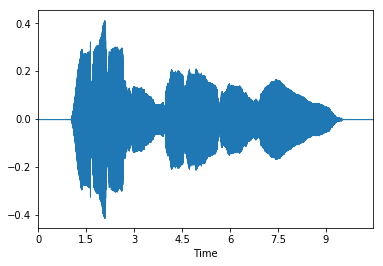

In [5]:
'''
display the wave plot
'''
librosa_disp.waveplot(x, sr)

In [6]:
'''
Detect onsets in the most simple way.
Frames are small windows each containing some
fixed number of samples

These functions have some default arguments we
aren't setting here that can change the frame size.

These onsets may or may not yet be perfect.
'''
onset_frames = librosa.onset.onset_detect(x, sr)
onset_times = librosa.frames_to_time(onset_frames, sr)
print(onset_frames)
print(onset_times)

[ 45  70  92  94 115 170 173 180 196 241 279 298 368 410]
[1.04489796 1.62539683 2.13623583 2.18267574 2.67029478 3.94739229
 4.01705215 4.17959184 4.55111111 5.59600907 6.47836735 6.91954649
 8.54494331 9.52018141]


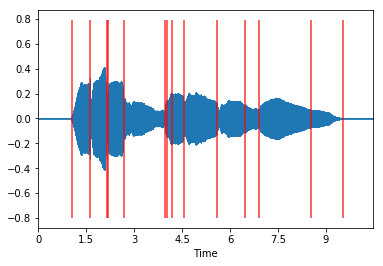

In [7]:
'''
Display waveplot but with vertical lines
on our detected onsets.
'''
librosa_disp.waveplot(x, sr=sr)
plt.vlines(onset_times, -0.8, 0.79, color='r', alpha=0.8)

In [8]:
'''
We can make a click track at the onsets
and play the original signal with the click track by adding them.

Are the onsets perfect? Not really.
'''
clicks = librosa.clicks(frames=onset_frames, sr=sr, length=len(x))
IPython.display.Audio(x + clicks,rate=sr)

In [9]:
'''
We can try a fancier method.

The first onset function is what we used before
The second is a bit fancier and sets a threshold
for what counts as an onset.
'''
def get_onsets(x,sr):
    onset_frames = librosa.onset.onset_detect(x, sr)
    onset_times = librosa.frames_to_time(onset_frames, sr)
    return onset_times, onset_frames

def get_onsets_fancy(x, sr):
    onset_frames = librosa.onset.onset_detect(x, sr=sr)
    all_strengths = librosa.onset.onset_strength(x,sr=sr)
    onset_strengths = all_strengths[onset_frames]
    frames_strengths = zip(onset_frames,onset_strengths)
    mean = numpy.mean(onset_strengths)
    var = numpy.var(onset_strengths)
    thresh = mean - (.4*var)
    filtered_onset_frames = [frame for frame,strength in frames_strengths if strength > thresh]
    frames = filtered_onset_frames
    times = librosa.frames_to_time(filtered_onset_frames, sr)
    return times, frames

'''
Notice our two choices follow the same interface (same inputs, same outputs)
That's useful for experimenting with the two of them.
'''
onset_times, onset_frames = get_onsets_fancy(x,sr)
clicks = librosa.clicks(frames=onset_frames, sr=sr, length=len(x))
IPython.display.Audio(x + clicks,rate=sr)

/Users/torch/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


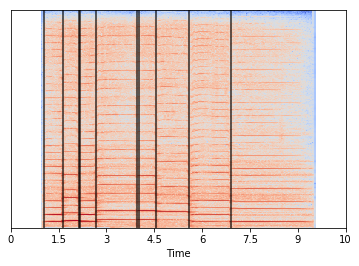

In [10]:
'''
compute the short-time fourier transform.

This gives us a numpy array with 2 axes 
(like a matrix / grid of numbers).
It has num_frequencies rows and
num_time_windows columns.

The number of frequencies and size of the time
windows are again some parameters whose default values
we use here. See the documentation for changing these
parameters.

Each entry (say in the j^th row
and k^th column) is a complex number 
c = a + bi
'''
S = librosa.stft(x)
'''
Say we are looking in the j'th row and k'th column
of S:

c = S[j,k]

Then the magntidue of c
shows how present frequency j is in time window k

In numpy, numpy.abs() takes the absolute value
of a real number or the magnitude of a complex number.
'''
abs_S = numpy.abs(S)


'''
The magnitudes of very present frequencies
(like fundamentals) can be larger by 100s or 1000s
of times than the magnitudes of quiet partials.
To be able to visualize them correctly, we usually
plot their logarithms.

Remember log base 10 of a number x means,
to which power should you raise 10 to get x?
This means log base 10 of the sequence
[10,100,1000] would turn it into
[1,2,3]. Thus, it would be easier to plot
these numbers because the differnce between them
wouldn't be so large.
'''
logS = numpy.log(abs_S)

'''
Finally, use librosa's function for viewing spectrograms.
Again, also plot the onsets.
'''
librosa_disp.specshow(logS, sr=sr, x_axis='time')
plt.vlines(onset_times, 0, logS.shape[0], color='k', alpha=0.8)

In [11]:
'''
For pitch estimation of each segment between onsets,
we have several choices of method. How well these work
depend on how rich of a signal it is.

For example, for a pure sin wave at constant freqency, 
just counting the number of times the amplitude crosses zero
is a good way to find the number of periods per second.

However, for a rich signal, a partial may make
the signal cross zero extra times when the fundamental
frequency is near 0.

Below is the zero crossing method, which we tried
but didn't work too well.

Here is also the auto-correlation method, which works better.

We also talked about some alternative methods like
computing the spectrogram and taking the frequency
with largest magnitude. This might be fine in many cases
but wouldn't work for an instrument whose partials are louder
than its fundamentals.

Tricky!
'''
# zero crossing method
def estimate_pitch_zcr(x,fs):
    zero_crossings = librosa.zero_crossings(x)
    num_seconds = len(x)/float(fs)
    num_periods = sum(zero_crossings)/2
    return num_periods/num_seconds

# auto correlation method
def estimate_pitch_auto(segment, fs, fmin=50.0, fmax=2000.0):
    i_min = int(fs/fmax)
    i_max = int(fs/fmin)
    r = librosa.autocorrelate(segment)
    r[:i_min] = 0
    r[i_max:] = 0
    i = r.argmax()
    f0 = float(fs)/i
    # fundamental frequency
    return f0


In [12]:
'''
Simple function for generating a sine wave.
'''
def generate_sine(f0, sr, n_duration):
    n = numpy.arange(n_duration)
    return 0.2*numpy.sin(2*numpy.pi*f0*n/float(sr))

In [13]:
'''
Putting it all together,
given a signal called signal_in,
- get the onsets
- between each onset, transcribe pitch
- generate a sine wave with that pitch

We incrementally write these sines
into a new signal called signal_out
'''
def transcribe_pitch(signal_in, fs):
    
    # initialize output signal
    signal_out = numpy.zeros(len(signal_in))
    
    '''
    pick one of these to get onsets
    onset_times, onset_frames
    
    '''
    #onset_times,onset_frames = get_onsets(signal_in, fs)
    onset_times,onset_frames = get_onsets_fancy(signal_in, fs)
    
    # get pitches
    for i in range(len(onset_times)-1):
        n0 = int(onset_times[i]*fs)
        n1 = int(onset_times[i+1]*fs)
        segment = signal_in[n0:n1]
        
        '''
        pick one of these to estimate pitch  of segment
        '''
        #pitch = estimate_pitch_zcr(segment, fs)
        pitch = estimate_pitch_auto(segment, fs, fmin=50.0, fmax=2000.0)
        
        # write generated segment to new signal
        signal_out[n0:n1] = generate_sine(pitch, fs, n1-n0)
        
    return signal_out


In [14]:
y = transcribe_pitch(x,sr)

In [15]:
'''
original
'''
IPython.display.Audio(x, rate=sr)

In [16]:
'''
transcription

Sounds decent. A wrong octave and a missing note.
Can you improve this? Don't mind the clicking
in the generated sine recording. That's just
because the amplitude of the signal jumps
from some non-zero number suddenly to 0
when we generate the next segment's sine wave.
'''
IPython.display.Audio(y, rate=sr)